In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack 
using Plots
using OrdinaryDiffEq

In [3]:
# Parameters
grid_resolution        = 100
quadrature_order       = 5
selected_ev            = 2        # which Eigenvector to choose
ϵ                      = 0.2      # perturbation
t₀                      = 0.6     # parameter value corresponding to ϵ=0
solver_tolerance       = 1e-5
solver                 = OrdinaryDiffEq.BS5();

In [4]:
rot_double_gyre = @velo_from_stream Ψ_rot_dgyre begin
    st          = heaviside(t)*heaviside(1-t)*t^2*(3-2*t) + heaviside(t-1)
    heaviside(x)= 0.5*(sign(x) + 1)
    Ψ_P         = sin(2π*x)*sin(π*y)
    Ψ_F         = sin(π*x)*sin(2π*y)
    Ψ_rot_dgyre = (1-st) * Ψ_P + st * Ψ_F
end
T(x,p) = flow(rot_double_gyre, x, [0.0, t₀ + p],
    tolerance = solver_tolerance, solver = solver)[end];

In [5]:
LL, UR = (0.0, 0.0), (1.0, 1.0)
ctx, _ = regularTriangularGrid((grid_resolution, grid_resolution), LL, UR, quadrature_order = quadrature_order);

In [6]:
M = assembleMassMatrix(ctx);

In [7]:
# assemble K
DT₀(x) = linearized_flow_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀);

 17.588471 seconds (65.20 M allocations: 3.724 GiB, 6.84% gc time)


In [8]:
# solve the linear system
@time λ₀, u₀ = eigs(K, M, which=:SM)
@assert all(imag.(u₀) .== 0)
@assert all(imag.(λ₀) .== 0)
u₀ = real.(u₀[:,selected_ev])
λ₀ = real.(λ₀[selected_ev])
u₀ = u₀ ./ sqrt(u₀'*M*u₀)        # L2 normalization
if u₀[Int(floor(0.5*grid_resolution*grid_resolution+0.25*grid_resolution))]>0
    u₀ = -u₀                    # eigs is nondeterministic with respect to the sign, so normalize
end
λ₀

  3.071438 seconds (9.52 M allocations: 538.920 MiB, 4.97% gc time)


-53.855535543387205

In [9]:
# assemble the linear response matrix L
Adot = x -> linear_response_tensor(T, x, 0)
@time L = assembleStiffnessMatrix(ctx, Adot);

 31.548918 seconds (55.75 M allocations: 4.303 GiB, 2.67% gc time)


In [10]:
# solve the system for the derivative u_dot
lhs = [K-λ₀*M   -M*u₀
        u₀'*M      0]
rhs = [-L*u₀    ;  0]

@time b = lhs \ rhs
u_dot = b[1:end-1]
λ_dot = b[end]

  0.657659 seconds (2.41 M allocations: 135.745 MiB, 3.86% gc time)


-69.87367990582501

In [11]:
# calculate the exact uϵ
DTϵ(x) = linearized_flow_autodiff(y -> T(y,ϵ) , x)
Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
Kϵ = assembleStiffnessMatrix(ctx, Aϵ)
λϵ, uϵ = eigs(Kϵ, M, which=:SM)
@assert all(imag.(uϵ) .== 0)
@assert all(imag.(λϵ) .== 0)
uϵ = real.(uϵ[:,selected_ev])
λϵ = real.(λϵ[selected_ev])
uϵ = uϵ ./ sqrt(uϵ'*M*uϵ)
if uϵ[Int(floor(0.5*grid_resolution*grid_resolution+0.25*grid_resolution))]>0
    uϵ = -uϵ
end
λϵ

-70.63602428315596

In [12]:
λ₀ + ϵ*λ_dot

-67.83027152455222

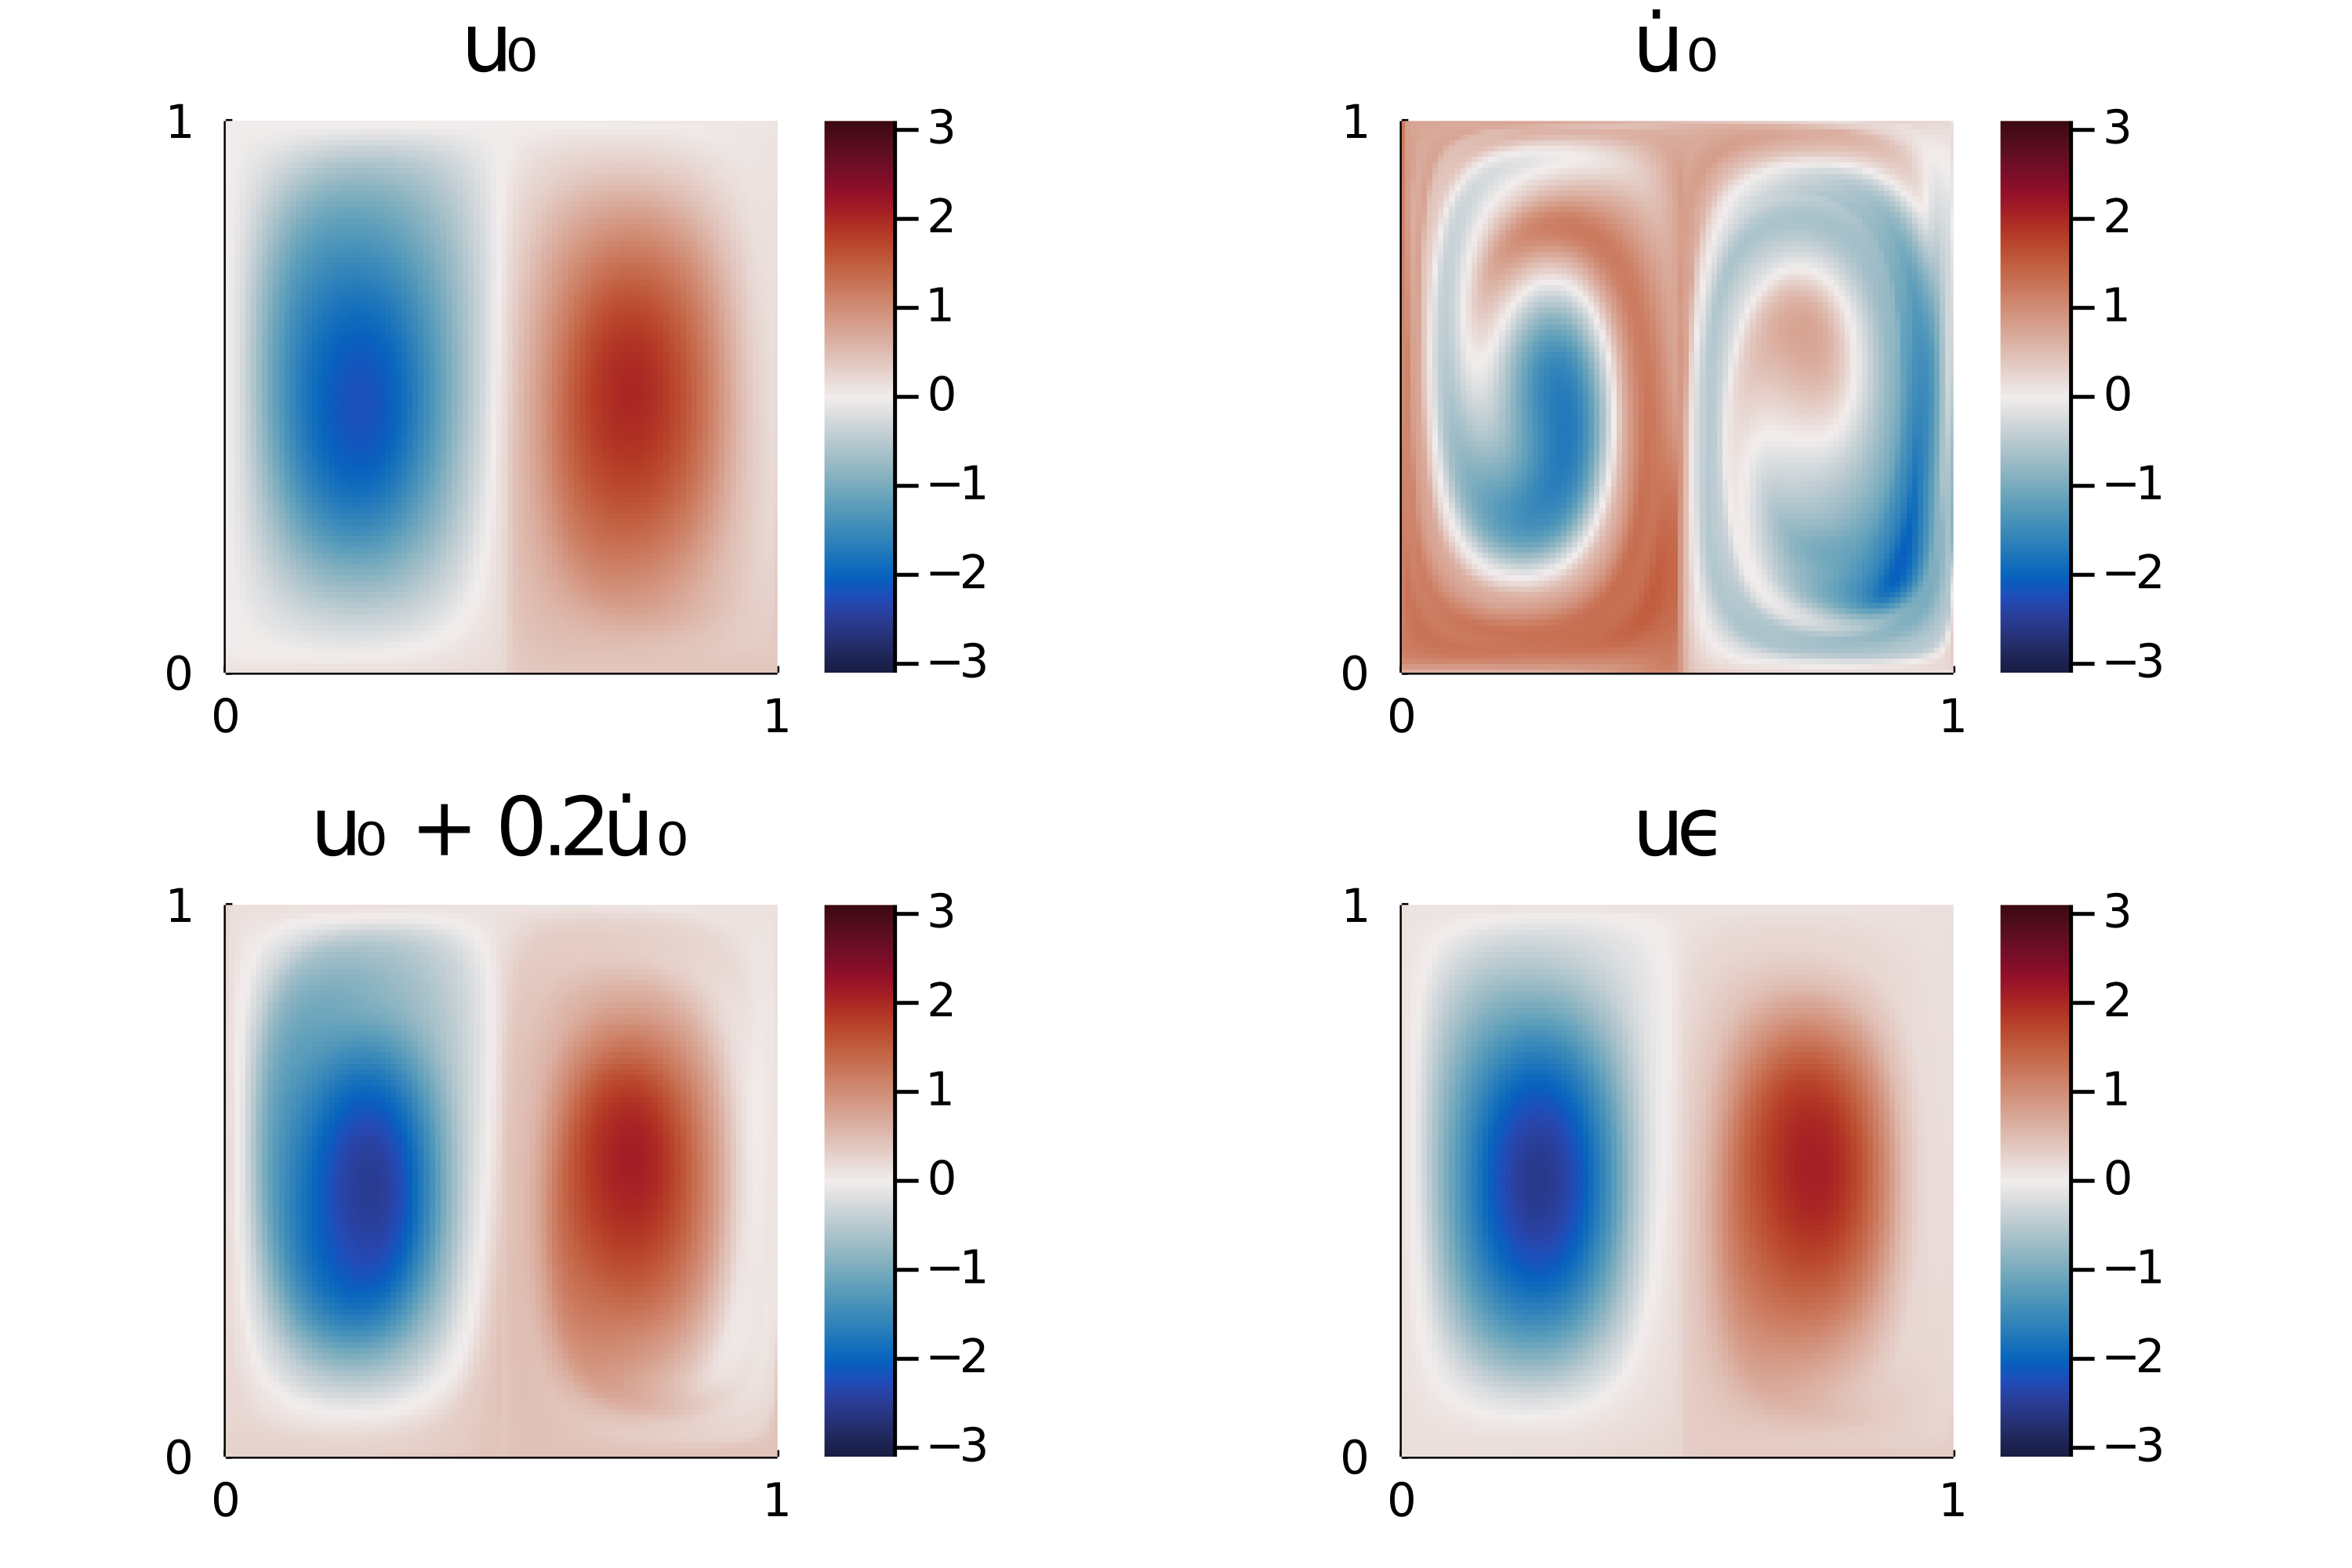

In [13]:
color =    :balance
xticks =   0:1:1
yticks =   0:1:1
colorbar = :left
cmin =     -3.1
cmax =     3.1
#unfortunately there is no option for colorbar ticks


original      = plot_u(ctx, u₀,  grid_resolution, grid_resolution, title="u₀",
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
derivative    = plot_u(ctx, u_dot,       grid_resolution, grid_resolution, title="u̇ ₀",
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
extrapolated  = plot_u(ctx, u₀ + ϵ*u_dot, grid_resolution, grid_resolution, title="u₀ + $(ϵ)u̇ ₀",
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
exact         = plot_u(ctx, uϵ,          grid_resolution, grid_resolution, title="uϵ",
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
Plots.plot(original,derivative,extrapolated,exact, fmt=:png, dpi=500)

In [14]:
using Contour

In [15]:
function dynamic_cheeger_value_levelset(levelset)
    curves = lines(levelset)
    if length(curves) != 1 
        @warn "Currently only connected levelsets are allowed! Levelset: ", level(levelset)
    end
    curve = curves[1]
    return dynamic_cheeger_value(ctx,curve,x -> T(x,0),tolerance=1e-10)
end
function dynamic_cheeger_value_levelset_nonnegative(levelset)
    if level(levelset) < 0
        return Inf
    end
    curves = lines(levelset)
    if length(curves) != 1 
        @warn "Currently only connected levelsets are allowed! Levelset: $(level(levelset))"
    end
    curve = curves[1]
    return dynamic_cheeger_value(ctx,curve,x -> T(x,0),tolerance=1e-10)
end

best_levelset, best_value = get_minimal_levelset(
    ctx,u₀,dynamic_cheeger_value_levelset_nonnegative,n_candidates=1000)
print("Dynamic Cheeger value:\t",best_value,"\n")
print("Levelset:\t\t",level(best_levelset),"\n")

┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0064855954739373445
└ @ Main In[15]:15


Dynamic Cheeger value:	6.389227023561188
Levelset:		0.0022440937736267763


┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.010727097174248357
└ @ Main In[15]:15


cheeger value		length			length transported	volume
8.607828883891994	1.7311118510670425	1.6705898942834987	0.19759348095988613
6.389227023561188	2.765978062577851	3.105111471744991	0.4594522555445565


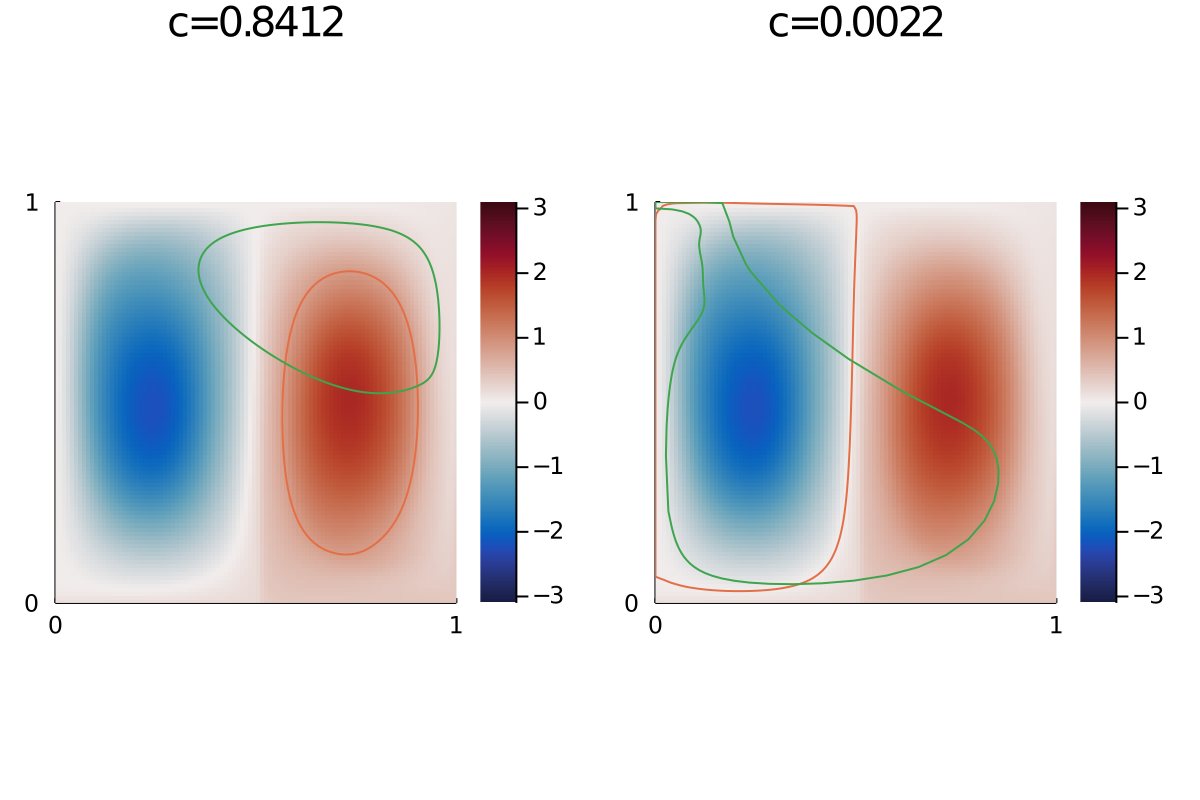

In [16]:
# value from paper
c_paper = 0.8412
plot_paper = plot_u(ctx, u₀,  grid_resolution, grid_resolution, title="c=$(round(c_paper,digits=4))",
        colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks,legend=false)

curve = lines(get_levelset(ctx, u₀, c_paper))[1]
curve_moved = Main.CoherentStructures.apply2curve(x->T(x,0),curve)

cheeger_value = dynamic_cheeger_value(ctx, curve, x->T(x,0))
print("cheeger value\t\tlength\t\t\tlength transported\tvolume\n")
print("$(cheeger_value)\t$(Main.CoherentStructures.getLength(curve))\t",
    "$(Main.CoherentStructures.getLength(curve_moved))\t$(Main.CoherentStructures.getEuclideanArea(ctx,curve))\n")

Plots.plot!(coordinates(curve))
Plots.plot!(coordinates(curve_moved))

# our value
c_ours = level(best_levelset)
plot_ours = plot_u(ctx, u₀,  grid_resolution, grid_resolution, title="c=$(round(c_ours,digits=4))",
        colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks,legend=false)

curve = lines(get_levelset(ctx, u₀, c_ours))[1]
curve = Main.CoherentStructures.closeCurve(ctx,curve)
curve_moved = Main.CoherentStructures.apply2curve(x->T(x,0),curve)

cheeger_value = dynamic_cheeger_value(ctx, curve, x->T(x,0))
print("$(cheeger_value)\t$(Main.CoherentStructures.getLength(curve))\t",
    "$(Main.CoherentStructures.getLength(curve_moved))\t$(Main.CoherentStructures.getEuclideanArea(ctx,curve))\n")

Plots.plot!(coordinates(curve))
Plots.plot!(coordinates(curve_moved))


Plots.plot(plot_paper, plot_ours, fmt=:png,dpi=200)

In [17]:
function plot_vectorfield(xs,ys,dx,dy;scale=1,step=1)
    xs, ys = xs[1:step:end], ys[1:step:end]
    x_coords = repeat(xs, outer=length(ys))
    y_coords = repeat(ys, inner=length(xs))
    dx, dy = scale.*dx[1:step:end,1:step:end], scale.*dy[1:step:end,1:step:end]
    quiver(x_coords,y_coords,quiver=(vec(dx),vec(dy)))
end

plot_vectorfield (generic function with 1 method)

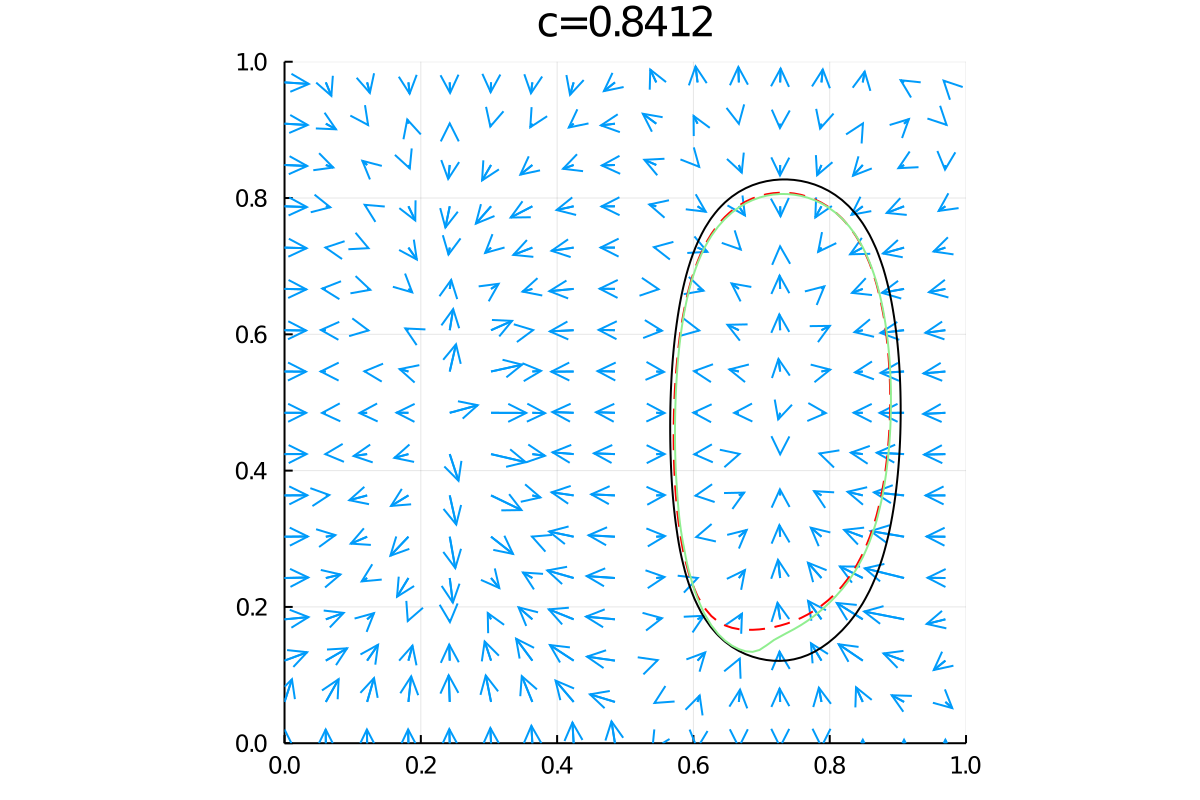

In [18]:
plot_vectorfield(get_levelset_evolution(ctx,u₀,u_dot)...,scale=0.03,step=6)
curve         = lines(get_levelset(ctx, u₀, c_paper))[1]
curve_epsilon = lines(get_levelset(ctx, uϵ, c_paper))[1]
curve_predcted= lines(get_levelset(ctx, u₀ + ϵ*u_dot, c_paper))[1]

plot!(coordinates(curve),color=:black)
plot!(coordinates(curve_epsilon),color=:red,linestyle=:dash)
plot!(coordinates(curve_predcted),color=:lightgreen)

Plots.plot!(fmt=:png,dpi=200,legend=false,aspectratio=1,xlims=(0,1),ylims=(0,1),title="c=$(round(c_paper,digits=4))")

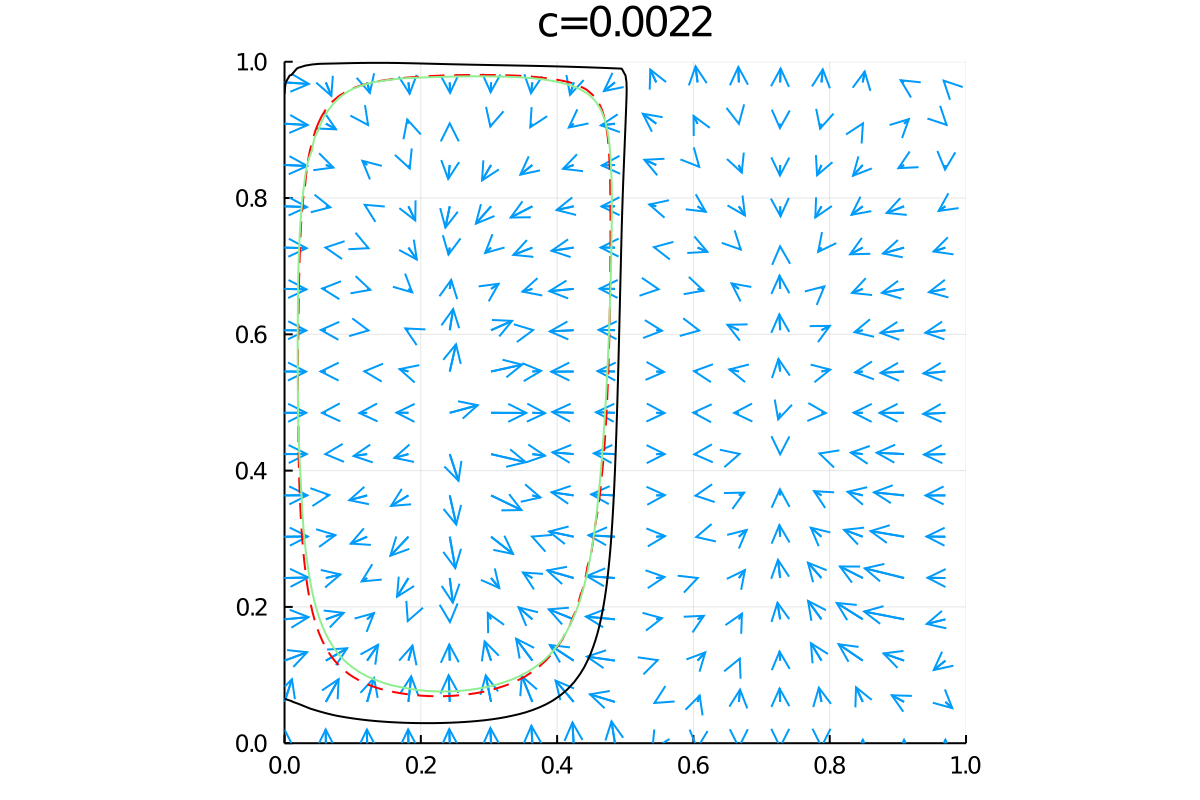

In [19]:
plot_vectorfield(get_levelset_evolution(ctx,u₀,u_dot)...,scale=0.03,step=6)
curve         = lines(get_levelset(ctx, u₀, c_ours))[1]
curve_epsilon = lines(get_levelset(ctx, uϵ, c_ours))[1]
curve_predcted= lines(get_levelset(ctx, u₀ + ϵ*u_dot, c_ours))[1]

plot!(coordinates(curve),color=:black)
plot!(coordinates(curve_epsilon),color=:red,linestyle=:dash)
plot!(coordinates(curve_predcted),color=:lightgreen)

Plots.plot!(fmt=:png,dpi=200,legend=false,aspectratio=1,xlims=(0,1),ylims=(0,1),title="c=$(round(c_ours,digits=4))")